#REAL-TIME MACHINE LEARNING(ECGR 5106)

HOMEWORK 3

Naseeruddin Lodge

In [100]:
!pip install d2l==1.0.0b0
!pip install ptflops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from d2l import torch as d2l
import ptflops
from ptflops import get_model_complexity_info


print(torch.__version__)
print(torchvision.__version__)

import tensorflow as tf
tf.test.gpu_device_name()

1.13.1+cu116
0.14.1+cu116


'/device:GPU:0'

#PROBLEM 1

1. Train the based line VGG model we need for FashinMNIST on CIFAR-10 and report your classification accuracy for validation set, as well as training loss and training accuracy. For this training resize the network input to 64*64 resolution.

In [3]:
# Loading the CIFAR10 Dataset 
class CIFAR10(d2l.DataModule):
  def __init__(self, resize, batch_size = 64):
    super().__init__()
    self.save_hyperparameters()
    trans = transforms.Compose([transforms.Resize(resize),
                                transforms.ToTensor()])
    self.train = torchvision.datasets.CIFAR10(
        root = self.root, train = True, transform = trans, download = True)
    self.val = torchvision.datasets.CIFAR10(
        root = self.root, train = False, transform = trans, download = True)

In [4]:
data = CIFAR10(resize = (64, 64))
print("Training Images   = ", len(data.train))
print("Validation Images = ", len(data.val))

data.train[0][0].shape

Files already downloaded and verified
Files already downloaded and verified
Training Images   =  50000
Validation Images =  10000


torch.Size([3, 64, 64])

In [5]:
# Assigning labels to numerical values so its is easier to read 
@d2l.add_to_class(CIFAR10)
def text_labels(self, indices):
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']
  return [labels[int(i)] for i in indices]

In [6]:
# Function to load either Training or Validation self
@d2l.add_to_class(CIFAR10)
def get_dataloader(self, train):
  data = self.train if train else self.val
  return torch.utils.data.DataLoader(data, self.batch_size, shuffle = train,
                                     num_workers = self.num_workers)
  
X, Y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, Y.shape, Y.dtype)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 3, 64, 64]) torch.float32 torch.Size([64]) torch.int64


In [7]:
def vgg_block(num_convs, out_channels):
  layers = []
  for _ in range(num_convs):
    layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return nn.Sequential(*layers)

In [8]:
class VGG(d2l.Classifier):
  def __init__(self, arch, lr=0.1, num_classes=10):
    super().__init__()
    self.save_hyperparameters()
    conv_blks = []
    for (num_convs, out_channels) in arch:
      conv_blks.append(vgg_block(num_convs, out_channels))
    self.net = nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
        nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [9]:
# Function to print a Model's Layer Summary given the shape
@d2l.add_to_class(d2l.Classifier) 
def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    for layer in self.net:
        X = layer(X)
        print(layer.__class__.__name__, 'output shape:\t', X.shape)

model = VGG(arch=((1, 64), (1, 128), (1, 256), (1, 512), (1, 512)))
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  29.13 M, 100.000% Params, 298.04 MMac, 100.000% MACs, 
  (0): Sequential(
    1.79 k, 0.006% Params, 7.86 MMac, 2.639% MACs, 
    (0): Conv2d(1.79 k, 0.006% Params, 7.34 MMac, 2.463% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.088% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 262.14 KMac,

In [10]:
# Function to Evaluate the Model's Accuracy
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if isinstance(net, nn.Module):
        net.eval()  
        if not device:
            device = next(iter(net.parameters())).device

    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [11]:
# Training Function 
def train(net, train_iter, val_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'val acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        val_acc = evaluate_accuracy_gpu(net, val_iter)
        animator.add(epoch + 1, (None, None, val_acc))
     

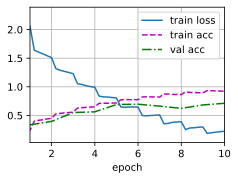

In [ ]:
lr, num_epochs = 0.1, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

2.Use Table 1 in the VGG paper (Simonyan and Zisserman, 2014) to construct other common models, such as VGG-16 or VGG-19. Train them on CIFAR-10, compare the accuracies, computational complexity and model size.


a. VGG-16

In [12]:
model_VGG16 = VGG(arch=((2,64), (2,128), (3,256), (3,512), (3,512)))
model_VGG16.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_VGG16.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  39.93 M, 100.000% Params, 1.28 GMac, 100.000% MACs, 
  (0): Sequential(
    38.72 k, 0.097% Params, 159.38 MMac, 12.445% MACs, 
    (0): Conv2d(1.79 k, 0.004% Params, 7.34 MMac, 0.573% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.020% MACs, )
    (2): Conv2d(36.93 k, 0.092% Params, 151.26 

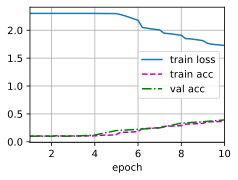

In [ ]:
lr, num_epochs = 0.01, 10
train(model_VGG16.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

b. VGG-19

In [13]:
model_VGG19 = VGG(arch=((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))
model_VGG19.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_VGG19.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 32, 32])
Sequential output shape:	 torch.Size([64, 128, 16, 16])
Sequential output shape:	 torch.Size([64, 256, 8, 8])
Sequential output shape:	 torch.Size([64, 512, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Flatten output shape:	 torch.Size([64, 2048])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 4096])
ReLU output shape:	 torch.Size([64, 4096])
Dropout output shape:	 torch.Size([64, 4096])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  45.24 M, 100.000% Params, 1.62 GMac, 100.000% MACs, 
  (0): Sequential(
    38.72 k, 0.086% Params, 159.38 MMac, 9.834% MACs, 
    (0): Conv2d(1.79 k, 0.004% Params, 7.34 MMac, 0.453% MACs, 3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(0, 0.000% Params, 262.14 KMac, 0.016% MACs, )
    (2): Conv2d(36.93 k, 0.082% Params, 151.26 M

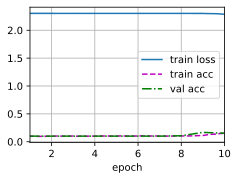

In [ ]:
lr, num_epochs = 0.01, 10
train(model_VGG19.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 2

1.Use the CIFAR-10 to train a baseline classifier based on the GoogleNet model we did in lectures for 64*64 input resolution. Report your classification accuracy for the validation set, as well as training loss and training accuracy.

In [14]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

In [15]:
class GoogleNet(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [16]:
@d2l.add_to_class(GoogleNet)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [17]:
@d2l.add_to_class(GoogleNet)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [18]:
@d2l.add_to_class(GoogleNet)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [19]:
@d2l.add_to_class(GoogleNet)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

In [20]:
@d2l.add_to_class(GoogleNet)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [21]:
model_GoogleNet = GoogleNet()
model_GoogleNet.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model_GoogleNet.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 192, 8, 8])
Sequential output shape:	 torch.Size([64, 480, 4, 4])
Sequential output shape:	 torch.Size([64, 832, 2, 2])
Sequential output shape:	 torch.Size([64, 1024])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  5.98 M, 100.000% Params, 129.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.47 k, 0.158% Params, 9.83 MMac, 7.576% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.475% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(0, 0.000% Params, 65.54 KMac, 0.051% MACs, )
    (2): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.051% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    114.94 k, 1.921% Params, 29.54 MMac, 22.766% MACs, 
    (0): Conv2d(4.16 k, 0.070% Params, 1.06 MMac, 0.821% MACs, 64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(0, 0.000% Params, 16.38 KMac, 0.013% MACs, )
  

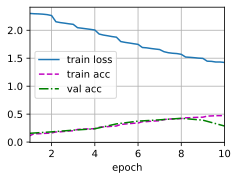

In [ ]:
lr, num_epochs = 0.01, 10
train(model_GoogleNet.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

2.Add batch normalization layer to GoogleNet (think about what is the best way of adding it). Train it again. Report your classification accuracy for the validation set, as well as training loss and training accuracy. Compare your accuracy against Problem2.1.


In [22]:
class Inception(nn.Module):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        self.bn1_1 = nn.BatchNorm2d(c1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.bn2_1 = nn.BatchNorm2d(c2[0])
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(c2[1])
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.bn3_1 = nn.BatchNorm2d(c3[0])
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        self.bn3_2 = nn.BatchNorm2d(c3[1])
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)
        self.bn4_2 = nn.BatchNorm2d(c4)

    def forward(self, x):
        b1 = F.relu(self.b1_1(x))
        b2 = F.relu(self.b2_2(F.relu(self.b2_1(x))))
        b3 = F.relu(self.b3_2(F.relu(self.b3_1(x))))
        b4 = F.relu(self.b4_2(self.b4_1(x)))
        return torch.cat((b1, b2, b3, b4), dim=1)

class GoogleNet_BatchNorm(d2l.Classifier):
  def b1(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3), nn.BatchNorm2d(64), 
        nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b2(self):
    return nn.Sequential(
        nn.LazyConv2d(64, kernel_size=1), nn.BatchNorm2d(64), nn.ReLU(),
        nn.LazyConv2d(192, kernel_size=3, padding=1), nn.BatchNorm2d(192), nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b3(self):
    return nn.Sequential(Inception(64, (96, 128), (16, 32), 32),
                         Inception(128, (128, 192), (32, 96), 64),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b4(self):
    return nn.Sequential(Inception(192, (96, 208), (16, 48), 64),
                         Inception(160, (112, 224), (24, 64), 64),
                         Inception(128, (128, 256), (24, 64), 64),
                         Inception(112, (144, 288), (32, 64), 64),
                         Inception(256, (160, 320), (32, 128), 128),
                         nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

@d2l.add_to_class(GoogleNet_BatchNorm)
def b5(self):
    return nn.Sequential(Inception(256, (160, 320), (32, 128), 128),
                         Inception(384, (192, 384), (48, 128), 128),
                         nn.AdaptiveAvgPool2d((1,1)), nn.Flatten())

@d2l.add_to_class(GoogleNet_BatchNorm)
def __init__(self, lr=0.1, num_classes=10):
    super(GoogleNet_BatchNorm, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1(), self.b2(), self.b3(), self.b4(),
                             self.b5(), nn.LazyLinear(num_classes))
    self.net.apply(d2l.init_cnn)

In [23]:
model = GoogleNet_BatchNorm()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 192, 8, 8])
Sequential output shape:	 torch.Size([64, 480, 4, 4])
Sequential output shape:	 torch.Size([64, 832, 2, 2])
Sequential output shape:	 torch.Size([64, 1024])
Linear output shape:	 torch.Size([64, 10])
Sequential(
  6.0 M, 100.000% Params, 130.02 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.160% Params, 9.96 MMac, 7.662% MACs, 
    (0): Conv2d(9.47 k, 0.158% Params, 9.7 MMac, 7.460% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.002% Params, 131.07 KMac, 0.101% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.050% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.050% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    115.46 k, 1.925% Params, 29.67 MMac, 22.821% MACs, 
    (0): Conv2d(4.16 k, 0.069% Par

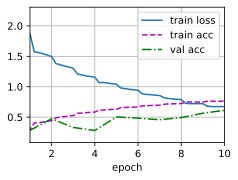

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 3

1.The baseline model we did in homework is called ResNet-18. Train that for CIFAR-10 and report and compare your validation accuracy against GoogleNet and VGGNet architectures you did. Can you compare the training time, model size and computation complexity across these three networks for CIFAR-10? Use 64*64 resolution across all training.


In [24]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [25]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [26]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

In [27]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

In [28]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

model = ResNet18()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  11.18 M, 100.000% Params, 148.76 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.086% Params, 9.96 MMac, 6.696% MACs, 
    (0): Conv2d(9.47 k, 0.085% Params, 9.7 MMac, 6.520% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.088% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.044% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.044% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    148.22 k, 1.325% Params, 37.95 MMac, 25.507% MACs, 
    (0): Residual(
  

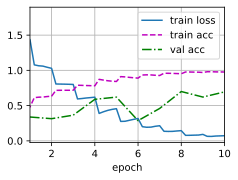

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

2.Build two new versions of ResNet (ResNet-26, and ResNet-32). Train them on CIFAR-10. Plot the training loss, training accuracy and validation accuracy. Compare the classification accuracy, computation complexity, and model size across these three versions of ResNet (18, 26, 32). How does the complexity grow as you increase the network depth?


ResNet-26

In [29]:
class ResNet26(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(( (2, 64), (2, 128), (2, 256), (2, 512), (2, 256), (2, 256) ),
                       lr, num_classes)

model = ResNet26()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 256, 1, 1])
Sequential output shape:	 torch.Size([64, 256, 1, 1])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  16.69 M, 100.000% Params, 154.27 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.058% Params, 9.96 MMac, 6.457% MACs, 
    (0): Conv2d(9.47 k, 0.057% Params, 9.7 MMac, 6.287% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.001% Params, 131.07 KMac, 0.085% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.042% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.042% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=

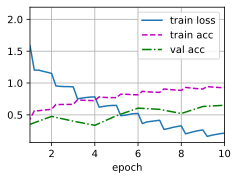

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

In [146]:
class ResNet32(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(( (3, 64), (3, 128), (3, 256), (3, 512), (3, 512) ),
                       lr, num_classes)
model = ResNet32()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 64, 16, 16])
Sequential output shape:	 torch.Size([64, 128, 8, 8])
Sequential output shape:	 torch.Size([64, 256, 4, 4])
Sequential output shape:	 torch.Size([64, 512, 2, 2])
Sequential output shape:	 torch.Size([64, 512, 1, 1])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  31.88 M, 100.000% Params, 238.87 MMac, 100.000% MACs, 
  (0): Sequential(
    9.6 k, 0.030% Params, 9.96 MMac, 4.170% MACs, 
    (0): Conv2d(9.47 k, 0.030% Params, 9.7 MMac, 4.060% MACs, 3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(128, 0.000% Params, 131.07 KMac, 0.055% MACs, 64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 65.54 KMac, 0.027% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 65.54 KMac, 0.027% MACs, kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (b2): Sequential(
    222.34 k, 0.697% Pa

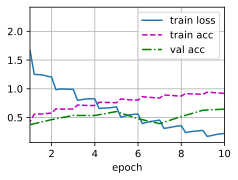

In [ ]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())

#PROBLEM 4
Extra Credit: Modify DenseNet such that the Computational complexity and number of parameters of DenseNet is similar to that of ResNet18.

In [60]:
def conv_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=3, padding=1))

In [61]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # Concatenate input and output of each block along the channels
            X = torch.cat((X, Y), dim=1)
        return X

In [65]:
def transition_block(num_channels):
    return nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.LazyConv2d(num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))

In [136]:
class DenseNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(128, kernel_size=13, stride=2, padding=1),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=11, stride=2))

In [148]:
@d2l.add_to_class(DenseNet)
def __init__(self, num_channels=64, growth_rate=128, arch=(4, 4, 4, 4),
             lr=0.1, num_classes=10):
    super(DenseNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, num_convs in enumerate(arch):
        self.net.add_module(f'dense_blk{i+1}', DenseBlock(num_convs,
                                                          growth_rate))
        # The number of output channels in the previous dense block
        num_channels += num_convs * growth_rate
        # A transition layer that halves the number of channels is added
        # between the dense blocks
        if i != len(arch) - 1:
            num_channels //= 2
            self.net.add_module(f'tran_blk{i+1}', transition_block(
                num_channels))
    self.net.add_module('last', nn.Sequential(
        nn.LazyBatchNorm2d(), nn.ReLU(),
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)


model = DenseNet()
model.layer_summary((64, 3, 64, 64))

macs, params = ptflops.get_model_complexity_info(model.net, (3, 64, 64))
print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
print('{:<30}  {:<8}'.format('Number of parameters: ', params))

Sequential output shape:	 torch.Size([64, 128, 9, 9])
DenseBlock output shape:	 torch.Size([64, 640, 9, 9])
Sequential output shape:	 torch.Size([64, 288, 4, 4])
DenseBlock output shape:	 torch.Size([64, 800, 4, 4])
Sequential output shape:	 torch.Size([64, 400, 2, 2])
DenseBlock output shape:	 torch.Size([64, 912, 2, 2])
Sequential output shape:	 torch.Size([64, 456, 1, 1])
DenseBlock output shape:	 torch.Size([64, 968, 1, 1])
Sequential output shape:	 torch.Size([64, 10])
Sequential(
  10.42 M, 100.000% Params, 238.99 MMac, 100.000% MACs, 
  (0): Sequential(
    65.28 k, 0.626% Params, 47.78 MMac, 19.991% MACs, 
    (0): Conv2d(65.02 k, 0.624% Params, 47.4 MMac, 19.835% MACs, 3, 128, kernel_size=(13, 13), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, 0.002% Params, 186.62 KMac, 0.078% MACs, 128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(0, 0.000% Params, 93.31 KMac, 0.039% MACs, )
    (3): MaxPool2d(0, 0.000% Params, 93.31 KMac, 0.039% M

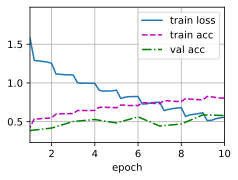

In [99]:
lr, num_epochs = 0.01, 10
train(model.net, data.get_dataloader(True), data.get_dataloader(False), num_epochs, lr, d2l.try_gpu())